In [55]:
import sqlite3
import sys
import os
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "..")))
from main import BuildModel
from src.data import SQLRepository
from src.data_utils import get_connection,combine_files
from arch import arch_model
import pandas as pd
import matplotlib.pyplot as plt


In [31]:
conn = get_connection()
repo= SQLRepository(conn)


In [32]:
build_model=BuildModel("scom_prices", repo)
returns =build_model.wrangle_data()

In [33]:
cutoff= int(len(returns) * 0.8)
results_train= returns.iloc[:cutoff]
results_test=returns.iloc[cutoff:]
results_test.shape

(500,)

In [34]:
model=build_model.fit_data(results_train,1,1)


***One Day Pred*** <br>
To make predictions we use 'model.forecast'. The last value in the results_train was on 2023-05-18 as shown above.The horizon parameter specifies the number of time steps (or periods) into the future for which the model will generate a forecast. So horizon =1 gives us the variance for the next trading day. Remember Garch model predicts variance so to obtain std dev(volatility) you have to find the squarerrot of the value.

In [46]:
forecasts=model.forecast(horizon=3, reindex=False).variance

So the predicted volatility for the next trading day was:

In [47]:
forecasts

,h.1,h.2,h.3
Date,,,
2023-05-18,26.29848,22.826745,19.87054


In [51]:
19.87054**.5

4.457638388205127

***Walk Forward Validation*** <br>
When the model has access to future data that is trying to predict, it often learns from it  causing overfitting and overestimates model performance. Essentially, the model 'cheats' because it knows what will happen in advance. Walk Foward  Validation solves this by allowing the model to be retrained for every new data that is available in the dataset.

In [53]:
#Empty list to hold our pred
predictions=[]
cutoff= int(len(returns) * 0.8)
test_size=len(returns)- int(len(returns) * 0.8)
for i in range(test_size):
    #Create test data
    returns_train = returns.iloc[:(cutoff + i)]
    model=build_model.fit_data(returns_train,1,1)
    # Generate next prediction (volatility, not to be confused with variance)
    next_pred=((model.forecast(horizon=1, reindex=False).variance).iloc[0,0]) ** .5
    # Append prediction to list we defined above
    predictions.append(next_pred)
# Create Series from predictions list
returns_test_wfv = pd.Series(predictions, index=returns.iloc[cutoff:].index)
print("returns_test_wfv type:", type(returns_test_wfv))
print("returns_wfv shape:", returns_test_wfv.shape)
returns_test_wfv.head()

returns_test_wfv type: <class 'pandas.core.series.Series'>
returns_wfv shape: (500,)


Date
2023-05-19    5.128204
2023-05-22    4.221598
2023-05-23    3.469923
2023-05-24    2.952359
2023-05-25    2.449389
dtype: float64

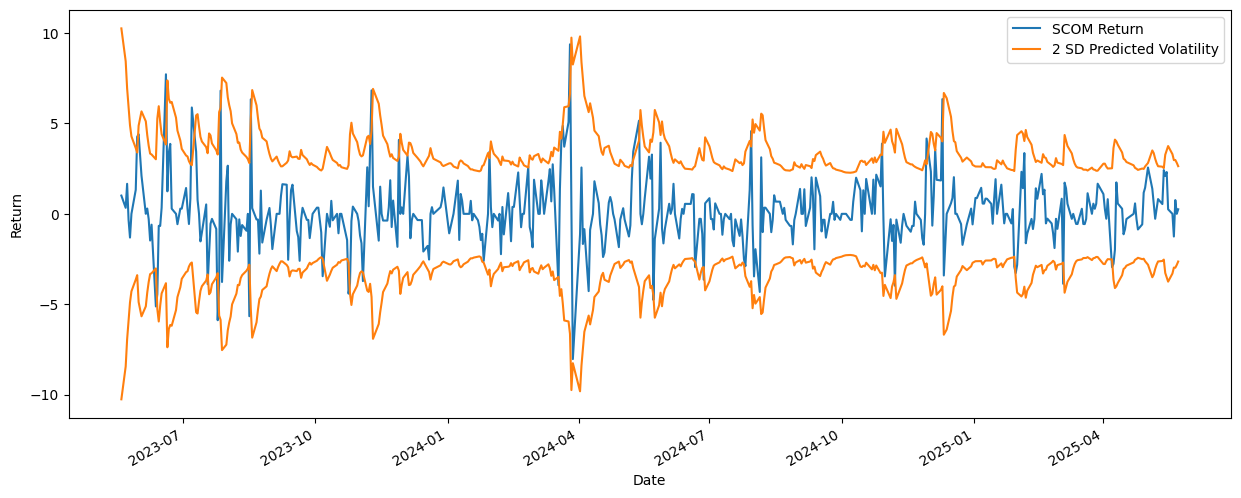

In [59]:
fig, ax = plt.subplots(figsize=(15, 6))

# Plot returns for test data
returns.tail(test_size).plot(ax=ax, label="SCOM Return")

# Plot volatility predictions * 2
( 2* returns_test_wfv).plot(ax=ax, c="C1", label="2 SD Predicted Volatility")

# Plot volatility predictions * -2
(-2 * returns_test_wfv).plot(ax=ax, c="C1")

# Label axes
plt.xlabel("Date")
plt.ylabel("Return")

# Add legend
plt.legend();

The model is performing well on the test data and is capturing periods of high and low volatilty which is evident on 2024-04(high volatilty) and early 2024(low volatility).

**10-day volatility forecast** 

In [71]:
# Generate 10-day volatility forecast
prediction = model.forecast(horizon=10, reindex=False).variance ** 0.5
print(prediction)

# Calculate forecast start date
start=prediction.index[0] + pd.DateOffset(days=1)

# Create date range
prediction_dates = pd.bdate_range(start=start,periods=prediction.shape[1])
prediction_dates[:3]

                h.01      h.02      h.03      h.04      h.05      h.06  \
Date                                                                     
2025-05-22  1.318274  1.391033  1.450054  1.498431  1.538386  1.571574   

                h.07      h.08      h.09      h.10  
Date                                                
2025-05-22  1.599263  1.622444  1.641906  1.658281  


DatetimeIndex(['2025-05-23', '2025-05-26', '2025-05-27'], dtype='datetime64[ns]', freq='B')

In [84]:
def clean_prediction(prediction):

    """Reformat model prediction to pandas series with dates as index.

    Parameters
    ----------
    prediction : pd.DataFrame
        Variance from a `ARCHModelForecast`

    Returns
    -------
    Series
        Forecast of volatility.
        Each value is predicted volatility.
    """
    # Calculate forecast start date

    start=prediction.index[0] + pd.DateOffset(days=1)

    # Create date range
    
    prediction_dates = pd.bdate_range(start=start,periods=prediction.shape[1])


    # Extract predictions from DataFrame, get square root
    data= prediction.values.flatten() ** .5

    # Combine `data` and `prediction_index` into Series
    prediction_series= pd.Series(data, index=prediction_dates, name="predicted_volatility")
    return prediction_series

In [85]:
prediction = model.forecast(horizon=10, reindex=False).variance
prediction_series=clean_prediction(prediction)
prediction_series

2025-05-23    1.318274
2025-05-26    1.391033
2025-05-27    1.450054
2025-05-28    1.498431
2025-05-29    1.538386
2025-05-30    1.571574
2025-06-02    1.599263
2025-06-03    1.622444
2025-06-04    1.641906
2025-06-05    1.658281
Freq: B, Name: predicted_volatility, dtype: float64